<a href="https://colab.research.google.com/github/logikon-ai/cot-eval/blob/main/notebooks/CoT_Leaderboard_Results_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the `/\/` Open CoT Leaderboard Results

## Setup

### Init

In [118]:
%pip install -Uq datasets seaborn GitPython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


In [119]:
EVAL_DATASET = "logikon/cot-eval-results"
TRACES_DATASET = "logikon/cot-eval-traces"
LOCAL_DIR = "cot-eval-results"
LOCAL_CONFIGS = "cot-traces"
SUBSETS = ["base","cot","orig"]

In [125]:
import getpass
from huggingface_hub import HfApi

HF_TOKEN = getpass.getpass("HF Token:")
API = HfApi(token=HF_TOKEN)
huggingface_hub.login(HF_TOKEN, add_to_git_credential=True)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
#!rm -r cot-eval-results
#!rm -r cot-traces

### Load evaluation results

In [167]:
from huggingface_hub import snapshot_download

snapshot_download(
    repo_id=EVAL_DATASET,
    revision="main",
    local_dir=LOCAL_DIR,
    repo_type="dataset",
    max_workers=60,
    token=HF_TOKEN
)


Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

(…)nai/tulu-2-7b/cot/24-01-31-11:05:58.json:   0%|          | 0.00/34.5k [00:00<?, ?B/s]

(…)ai/tulu-2-7b/base/24-01-31-11:05:58.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

(…)2-7b/orig/results_24-01-31-11:05:58.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

'/content/cot-eval-results'

In [168]:
# get all models for ehich results are stored
import glob

models = []
for path in glob.glob(f"{LOCAL_DIR}/data/*/*", recursive=False):
  models.append(path.replace(f"{LOCAL_DIR}/data/",""))
models

['Intel/neural-chat-7b-v3-1',
 'allenai/tulu-2-7b',
 'mistralai/Mistral-7B-Instruct-v0.2',
 'Deci/DeciLM-7B-instruct',
 'meta-llama/Llama-2-7b-hf']

In [169]:
import json

import pandas as pd

results = []

for model in models:
    for subset in SUBSETS:
        result_files = glob.glob(f"{LOCAL_DIR}/data/{model}/{subset}/**/*.json", recursive=True)
        for json_filepath in result_files:
            with open(json_filepath) as fp:
                data = json.load(fp)
            if "results" in data.keys():
                for k,v in data["results"].items():
                    record = v.copy()
                    record["model"] = model
                    record["subset"] = subset
                    results.append(record)

df_results = pd.DataFrame(results)
del results

In [171]:
def split_alias(alias: str) -> pd.Series:
    if alias[-5:]=="_base":
        alias = alias[:-5]
    elif alias[-4:]=="_cot":
        alias = alias[:-4]

    if "_" not in alias:
        task = alias
        config = ""
    else:
        config, task = alias.split("_")

    return pd.Series({"task": task, "config": config})

df_results = pd.concat([df_results, df_results.alias.apply(split_alias)], axis=1)

In [173]:
df_results.head()

,"acc,none","acc_stderr,none",alias,model,subset,task,config
0,0.381043,0.012253,adipisci-exercitationem_logiqa2_base,Intel/neural-chat-7b-v3-1,base,logiqa2,adipisci-exercitationem
1,0.309904,0.018498,adipisci-exercitationem_logiqa_base,Intel/neural-chat-7b-v3-1,base,logiqa,adipisci-exercitationem
2,0.243478,0.028361,adipisci-exercitationem_lsat-ar_base,Intel/neural-chat-7b-v3-1,base,lsat-ar,adipisci-exercitationem
3,0.315686,0.020601,adipisci-exercitationem_lsat-lr_base,Intel/neural-chat-7b-v3-1,base,lsat-lr,adipisci-exercitationem
4,0.446097,0.030364,adipisci-exercitationem_lsat-rc_base,Intel/neural-chat-7b-v3-1,base,lsat-rc,adipisci-exercitationem


In [175]:
df_tmp1 = df_results[df_results.subset.eq("cot")].sort_values(by=["model","task","config"])
df_tmp2 = df_results[df_results.subset.eq("base")].sort_values(by=["model","task","config"])

df_tmp1.reset_index(inplace=True, drop=True)
df_tmp2.reset_index(inplace=True, drop=True)

assert df_tmp1.config.to_list() == df_tmp2.config.to_list()
assert df_tmp1.model.to_list() == df_tmp2.model.to_list()
assert df_tmp1.task.to_list() == df_tmp2.task.to_list()

df_cot = df_tmp1[["model","task","config"]].copy()
df_cot["acc_cot"] = df_tmp1["acc,none"]
df_cot["acc_base"] = df_tmp2["acc,none"]

df_cot["delta_abs"] = df_cot.acc_cot - df_cot.acc_base
df_cot["delta_rel"] = (df_cot.acc_cot - df_cot.acc_base)/df_cot.acc_base


In [176]:
df_cot.head()

,model,task,config,acc_cot,acc_base,delta_abs,delta_rel
0,Deci/DeciLM-7B-instruct,logiqa,at-cumque,0.322684,0.284345,0.038339,0.134831
1,Deci/DeciLM-7B-instruct,logiqa,maiores-ducimus,0.330671,0.309904,0.020767,0.067010
2,Deci/DeciLM-7B-instruct,logiqa,odit-consectetur,0.290735,0.293930,-0.003195,-0.010870
3,Deci/DeciLM-7B-instruct,logiqa,quibusdam-libero,0.317891,0.295527,0.022364,0.075676
4,Deci/DeciLM-7B-instruct,logiqa,tenetur-eius,0.258786,0.300319,-0.041534,-0.138298


### Load CoT configuration data

In [177]:
from git import Repo

repo = Repo.clone_from("https://huggingface.co/datasets/logikon/cot-eval-traces", LOCAL_CONFIGS)

repo

<git.repo.base.Repo '/content/cot-traces/.git'>

In [178]:
COT_CONFIG_KEYS = ["cot_chain", "best_of", "use_beam_search", "temperature", "top_p", "top_k"]

def extract_config(message: str):
  config_dict = {}
  for line in message.split("\n"):
    line = line.strip()
    for key in COT_CONFIG_KEYS:
      if line.startswith(f"{key}:"):
        config_dict[key] = line.replace(f"{key}:","").strip()
  return config_dict



for c in repo.iter_commits(all=True, max_count=1, paths="ullam-consectetur-logiqa"):
  print(extract_config(c.message))

{'cot_chain': 'ReflectBeforeRun', 'best_of': '2', 'temperature': '0', 'top_k': '-1', 'top_p': '1.0', 'use_beam_search': 'true'}


In [179]:
cot_configs_data = {}

for cot_config_id in df_results.config.unique():
  if cot_config_id:
    c = next(repo.iter_commits(all=True, max_count=1, paths=f"{cot_config_id}-logiqa"))
    cot_configs_data[cot_config_id] = extract_config(c.message)


In [180]:
# add cot configs data to df_results
df_cot = pd.concat(
    [
        df_cot,
        df_cot.config.apply(lambda x: pd.Series(cot_configs_data[x]))
    ],
    axis=1
)


In [181]:
df_cot["decoding"] = "T:"+df_cot.temperature.astype(str) + "-BS:" + df_cot.use_beam_search.astype(str)

In [182]:
df_cot.head()

,model,task,config,acc_cot,acc_base,delta_abs,delta_rel,cot_chain,best_of,temperature,top_k,top_p,use_beam_search,decoding
0,Deci/DeciLM-7B-instruct,logiqa,at-cumque,0.322684,0.284345,0.038339,0.134831,ReflectBeforeRun,1,0.3,100,0.95,false,T:0.3-BS:false
1,Deci/DeciLM-7B-instruct,logiqa,maiores-ducimus,0.330671,0.309904,0.020767,0.067010,HandsOn,1,0,-1,1.0,false,T:0-BS:false
2,Deci/DeciLM-7B-instruct,logiqa,odit-consectetur,0.290735,0.293930,-0.003195,-0.010870,HandsOn,1,0.3,100,0.95,false,T:0.3-BS:false
3,Deci/DeciLM-7B-instruct,logiqa,quibusdam-libero,0.317891,0.295527,0.022364,0.075676,HandsOn,2,0,-1,1.0,true,T:0-BS:true
4,Deci/DeciLM-7B-instruct,logiqa,tenetur-eius,0.258786,0.300319,-0.041534,-0.138298,ReflectBeforeRun,2,0,-1,1.0,true,T:0-BS:true


## Exploration

#### CoT Accuracy Gains for Models and Tasks

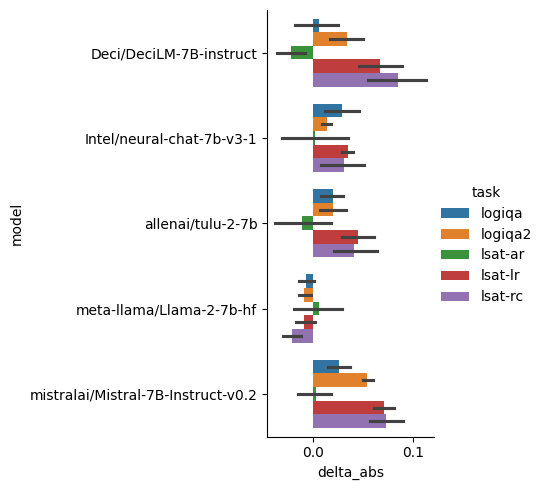

In [183]:
import seaborn as sns

sns.catplot(data=df_cot, hue="task", y="model", x="delta_abs", kind="bar")

#### CoT Accuracy Gains as a Function of Base Accuracy

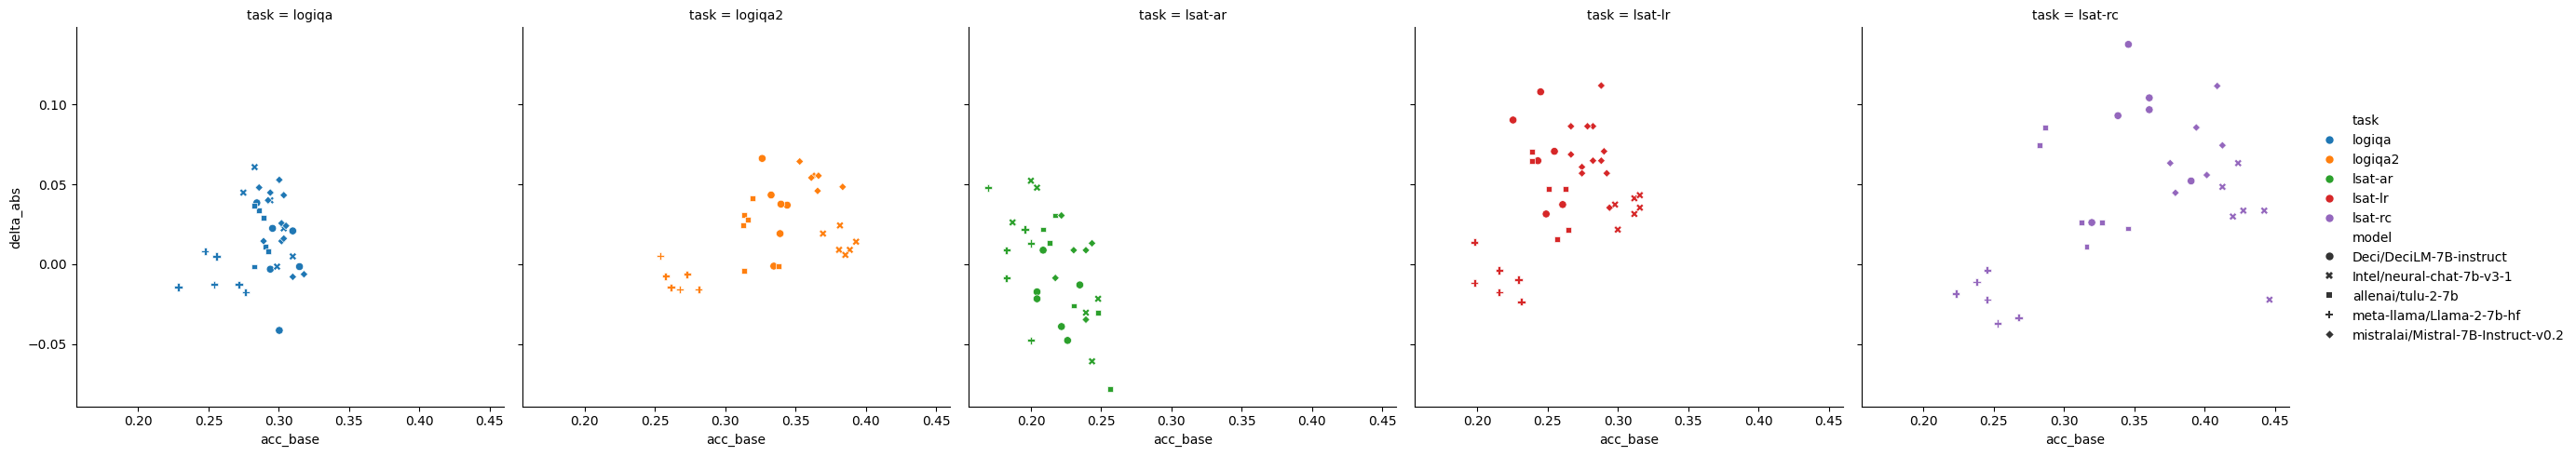

In [184]:
sns.relplot(data=df_cot, col="task", hue="task", style="model", y="delta_abs", x="acc_base", kind="scatter")

#### CoT Accuracy Gains as a Function of Reasoning Regime

(Averaged over all models.)

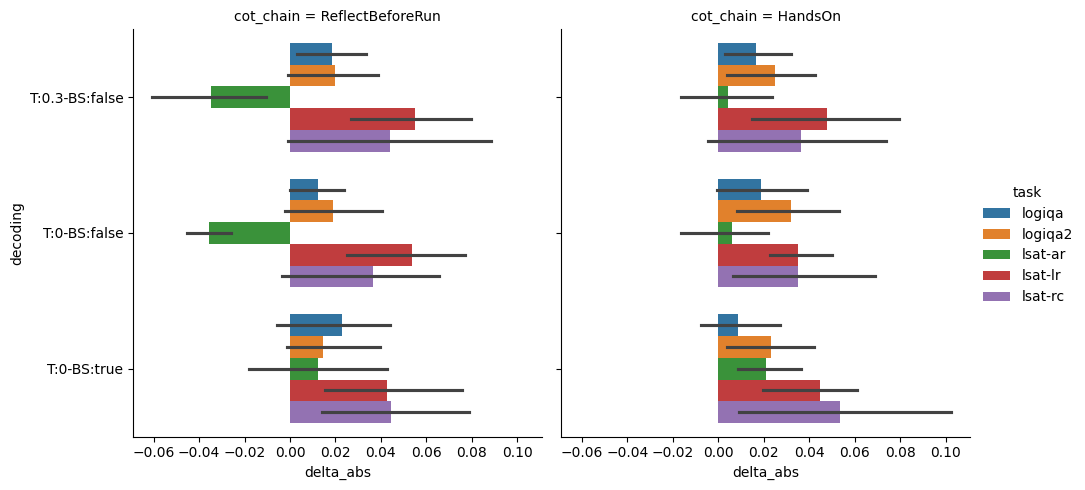

In [185]:
sns.catplot(data=df_cot, hue="task", y="decoding", x="delta_abs", kind="bar", col="cot_chain")